_______________________________

# Deep Learning for Advanced Practicioners
### Tutorial 01: Optimization
_______________________________


# Goal and Scope


_______________________________

In this course, we will focus the following question:

- Why is training DL models hard?
    - i.e., what is the main source of instability in Deep Net optimization?
    
This will enable us to understand the following phenomena:

- Why does Batch Normalization really work?
    - The main benefit of batch normalization
- Why do skip connections really work?
    - The main benefit of batch normalization
- Why do data-aware initialization schemes work? 
    - The main benefit of batch normalization

_______________________________
# Outline


_______________________________

#### 1. Observation [10 min.]

- ReLU MLPs collapse to a constant function at initialization.
- The same phenomenon happens with Convolutional Neural Networks.
- This is inevitable: Happens for all datasets, model hyperparameters, etc.

#### 2. Reason: Why does that happen? [20 min.]

- Intuition: Analysis of Kaiming initialization and loss of data-induced variance in ReLU networks.
- Theory: Deep Information Flow: Theory of activations distributions in infinite width neural networks.

#### 3. Consequence: Why is this a problem? [30 min.]

- This network is very difficult to train by gradient descent because:
    - A. Optimization is a fight between first and second order effects
    - B. First order derivatives: Vanishing gradients.
    - C. Second order derivatives: Explosion of second order effects

#### 4. Remedy: How can we solve this problem? [20 min.]

- Batch Normalization.
- Skip Connections.
- Data-aware initialization schemes.

#### 5. Discussion [30 min.]

#### 6. Additional pointers

- Practical tools
- Theory


In [1]:
import torch
# Global parameters
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 1024
dataset = "CIFAR10" # can be either of "MNIST", "CIFAR10" or any datset available in torchvision.datasets

_____________________________________
## 0. Helper code for Experiments:

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, nlayers, width):
        super().__init__()
        # Define architecture
        self.in_layer = nn.Linear(in_dim, width)
        self.out_layer = nn.Linear(width, out_dim, bias=False)
        self.layers = nn.ModuleList([nn.Linear(width, width) \
                                     for i in range(nlayers)])
        self.relu = nn.ReLU()
        
        # Initialize
        self.init_kaiming(self.in_layer)
        self.init_kaiming(self.out_layer)
        [self.init_kaiming(layer) for layer in self.layers]
        
    def forward(self, x):
        return self.get_activations(x)[-1]
        
    def get_activations(self, x):
        x = self.in_layer(x)
        preact = [x]
        for layer in self.layers:
            x = layer(self.relu(x))
            preact.append(x)
        x = self.out_layer(self.relu(x))
        preact.append(x) 
        return preact
    
    def init_kaiming(self, layer):
        with torch.no_grad():
            nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
            if layer.bias is not None:
                layer.bias.zero_()
                
def plot_batch(x, y):
    fig, ax = plt.subplots(4, 8, figsize=(16, 8))
    plt.axis('off')
    for i in range(4):
        for j in range(8):
            idx = i + 4*j
            ax[i,j].imshow(x[idx].numpy().transpose(1, 2, 0))
            ax[i,j].set_title(class_name(y[idx]))
            ax[i,j].axis('off')
            
def plot_model_outputs(imgs, lbls, out, N=3):
    fig, ax = plt.subplots(2, N, figsize=(N*5, 10), sharey='row')
    for idx in range(N):
        ax[0, idx].imshow(imgs[idx].numpy().transpose(1, 2, 0))
        ax[0, idx].set_title(class_name(lbls[idx]))
        ax[0, idx].axis('off')
        ax[1, idx].bar([class_name(i) for i in range(10)], out[idx].cpu().detach().numpy())
        labels = ax[1, idx].get_xticklabels()
        ax[1, idx].set_xticklabels([class_name(i) for i in range(10)], rotation=45)
        
def histogram(x, ax=plt, bins=50, **kwargs):
    if isinstance(x, torch.Tensor):
        x = to_numpy(x)
    ax.hist(x.flatten(), bins=bins, **kwargs)
    
to_numpy = lambda x:x.detach().cpu().numpy()
ds = DataLoader(getattr(datasets, dataset)("./tmp", download="True", transform=ToTensor()), batch_size=batch_size)
sample_batch = lambda : next(iter(ds)) 
class_name = lambda x: ds.dataset.classes[x]

Files already downloaded and verified


_____________________________________

## 1. Observation [10 min.]

- ReLU MLP collapses to a constant function at initialization.
- The same phenomenon happens with Convolutional Neural Networks.
- This is inevitable: Happens for all datasets, model hyperparameters, etc.

 Image tensor shape=(1024, 3, 32, 32), 
 Label tensor shape=(1024,)


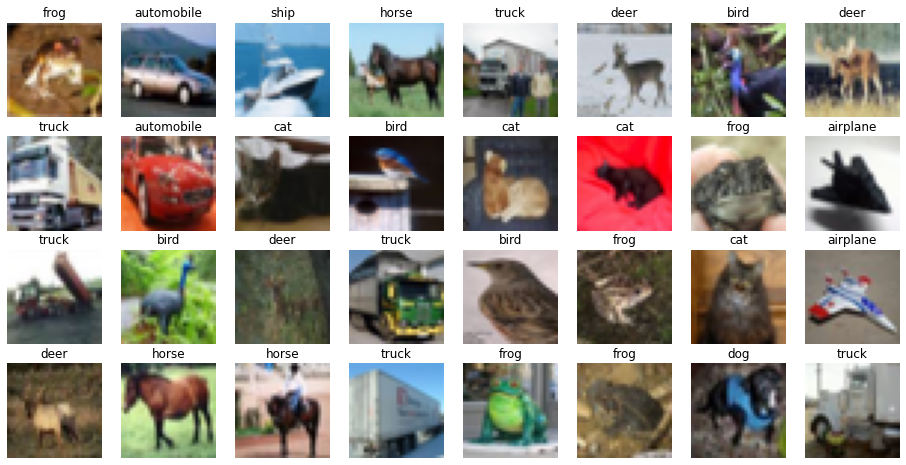

In [3]:
# Data
imgs, lbls = sample_batch()
print(f" Image tensor shape={tuple(imgs.shape)}, \n Label tensor shape={tuple(lbls.shape)}")
plot_batch(imgs, lbls)

In [4]:
# Model 
bs, channels, H, W = imgs.shape
input_dim = channels * H * W
output_dim = lbls.max().item() + 1

nlayers = 15
width = 2048

model = MLP(in_dim=input_dim, out_dim=output_dim, nlayers=nlayers, width=width).to(device)

print(f"Model is an MLP of {nlayers} layers of {width} neurons with ReLU activations")

Model is an MLP of 15 layers of 2048 neurons with ReLU activations


Overview of the model

![model_1](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_1.png)

<ipython-input-2-1b894957ab80>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, idx].set_xticklabels([class_name(i) for i in range(10)], rotation=45)


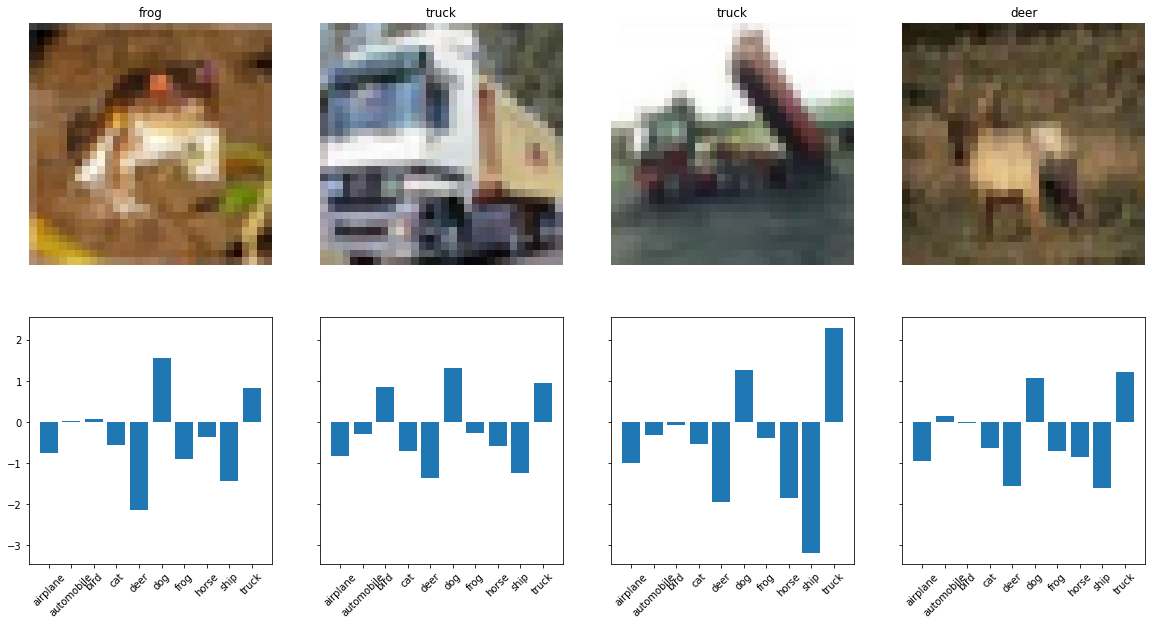

In [5]:
# Forward pass
x = ((imgs.view(batch_size, -1)  - imgs.mean()) / imgs.std()).to(device)
out = model(x)
plot_model_outputs(imgs, lbls, out, N=4)

#### Observation:

- The output of the model is (almost) the same for different inputs.
- The same phenomenon happens with Convolutional Neural Networks
- This is inevitable. No matter the dataset, the initialization, the model hyperparameters, etc.

_______________________________________
## 2. Reason [20 min.]

- Intuition: Analysis of Kaiming initialization and loss of data-induced variance in ReLU networks.
- Theory: Deep Information Flow: Theory of activations distributions in infinite width neural networks.

In [6]:
preactivations = model.get_activations(x)
print(f"\n We have {len(preactivations)} preactivations matrices (1 input layer + {nlayers} hidden layers + 1 output layer)")
print(f"\n Each preactivation is represented by a (batch size x feature dimension) = {tuple(preactivations[0].shape)} matrix")
print(f"\n Except the output that has shape of {tuple(preactivations[-1].shape)}")
print(f"\n They represent the input to the relu activation function for each layer ")


 We have 17 preactivations matrices (1 input layer + 15 hidden layers + 1 output layer)

 Each preactivation is represented by a (batch size x feature dimension) = (1024, 2048) matrix

 Except the output that has shape of (1024, 10)

 They represent the input to the relu activation function for each layer 


![model_1](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_1.png)

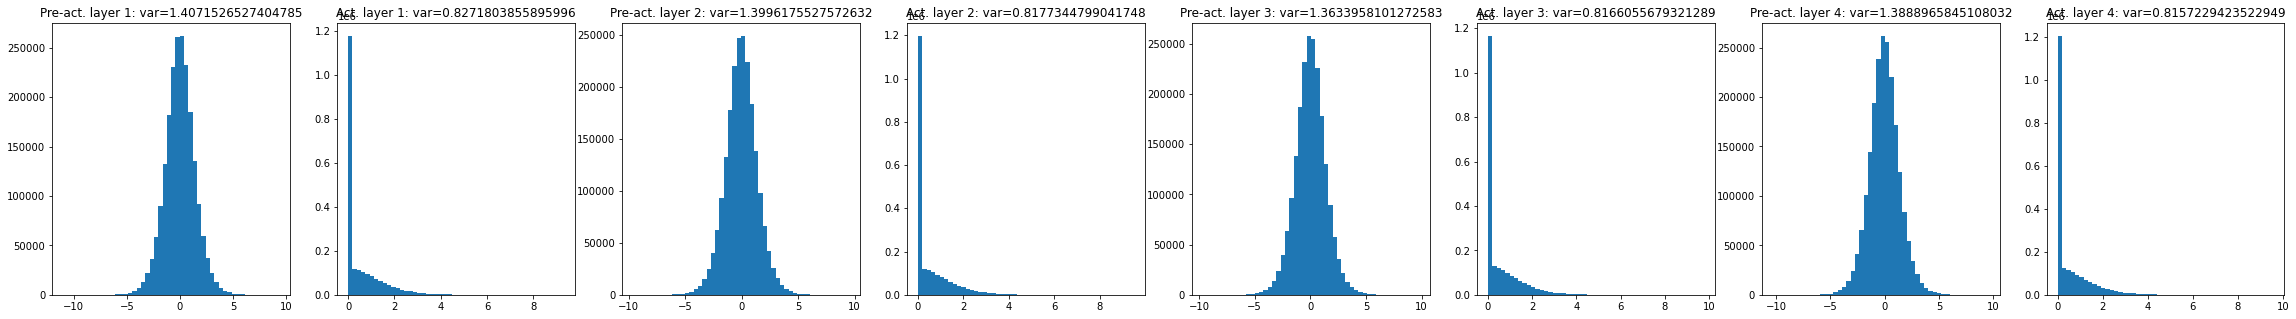

In [7]:
# TODO: Limit y axis of activations
fig, ax = plt.subplots(1, 8, figsize=(40, 5))
for i in range(4):
    preactivation = preactivations[i]
    activation = torch.nn.functional.relu(preactivation)
    histogram(preactivation, ax[i*2])
    histogram(activation, ax[i*2 + 1])
    ax[i*2].set_title(f"Pre-act. layer {i+1}: var={preactivation.std()}")
    ax[i*2+1].set_title(f"Act. layer {i+1}: var={activation.std()}")
    

Kaiming's initialization scheme preserves the variance of the activations accross the layers of the network:

With zero bias and weights initialized according to:

$W  \sim\mathcal{N}(0, \sqrt \frac{2}{n})$

If the weights were initialized with a different amplitude, then the activations would either explode or vanish with depth

_____________________________

Now let's look at the per-neuron activation ditribution:

In [8]:
layer_idx = 0
neuron_idx = 0
neuron_idxs = [0, 5, 9, 135, 1054]

In [9]:
preactivation = preactivations[layer_idx]
print(f"The total preactivation tensor has shape {tuple(preactivation.shape)}")
neuron_preactivation = preactivation[:,neuron_idxs[0]]
print(f"The per neuron preactivation tensor has shape {tuple(neuron_preactivation.shape)}")

The total preactivation tensor has shape (1024, 2048)
The per neuron preactivation tensor has shape (1024,)


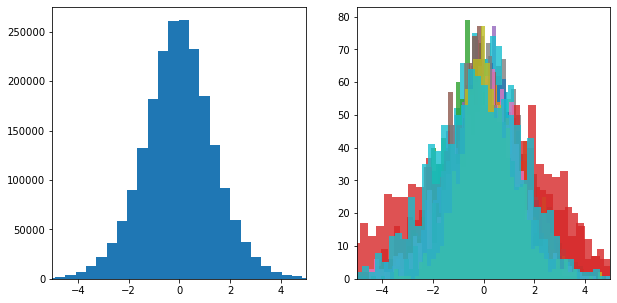

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].set_xlim(-5, 5)
ax[1].set_xlim(-5, 5)

histogram(preactivation, ax[0])

for neuron_idx in range(20):
    histogram(preactivation[:, neuron_idx], ax[1], alpha=.8)

![model_2](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_2.png)

### Observation:

Every neuron's preactivation is a well-behaved zero-mean Gaussian, with variance of approximately 2

Now let's look at the per-neuron distribution of the last layer

In [11]:
layer_idx = 15
neuron_idx = 0
neuron_idxs = [0, 5, 9, 135, 1054]

In [12]:
preactivation = preactivations[layer_idx]
print(f"The total preactivation tensor has shape {tuple(preactivation.shape)}")
neuron_preactivation = preactivation[:,neuron_idxs[0]]
print(f"The per neuron preactivation tensor has shape {tuple(neuron_preactivation.shape)}")

The total preactivation tensor has shape (1024, 2048)
The per neuron preactivation tensor has shape (1024,)


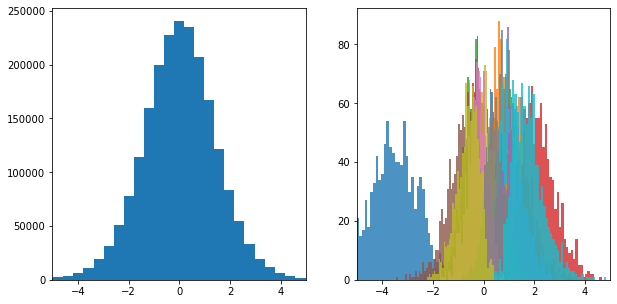

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].set_xlim(-5, 5)
ax[1].set_xlim(-5, 5)

histogram(preactivation, ax[0])

for neuron_idx in range(20):
    histogram(preactivation[:, neuron_idx], ax[1], alpha=.8)

![model_2](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_2.png)

### Observation:

- The full distribution of preactivations looks the same. However,

- Each neuron's preactivation has a Gaussian distribution with high mean and low variance.

Next, let's visualize how this phenomenon happens gradually along the model's depth

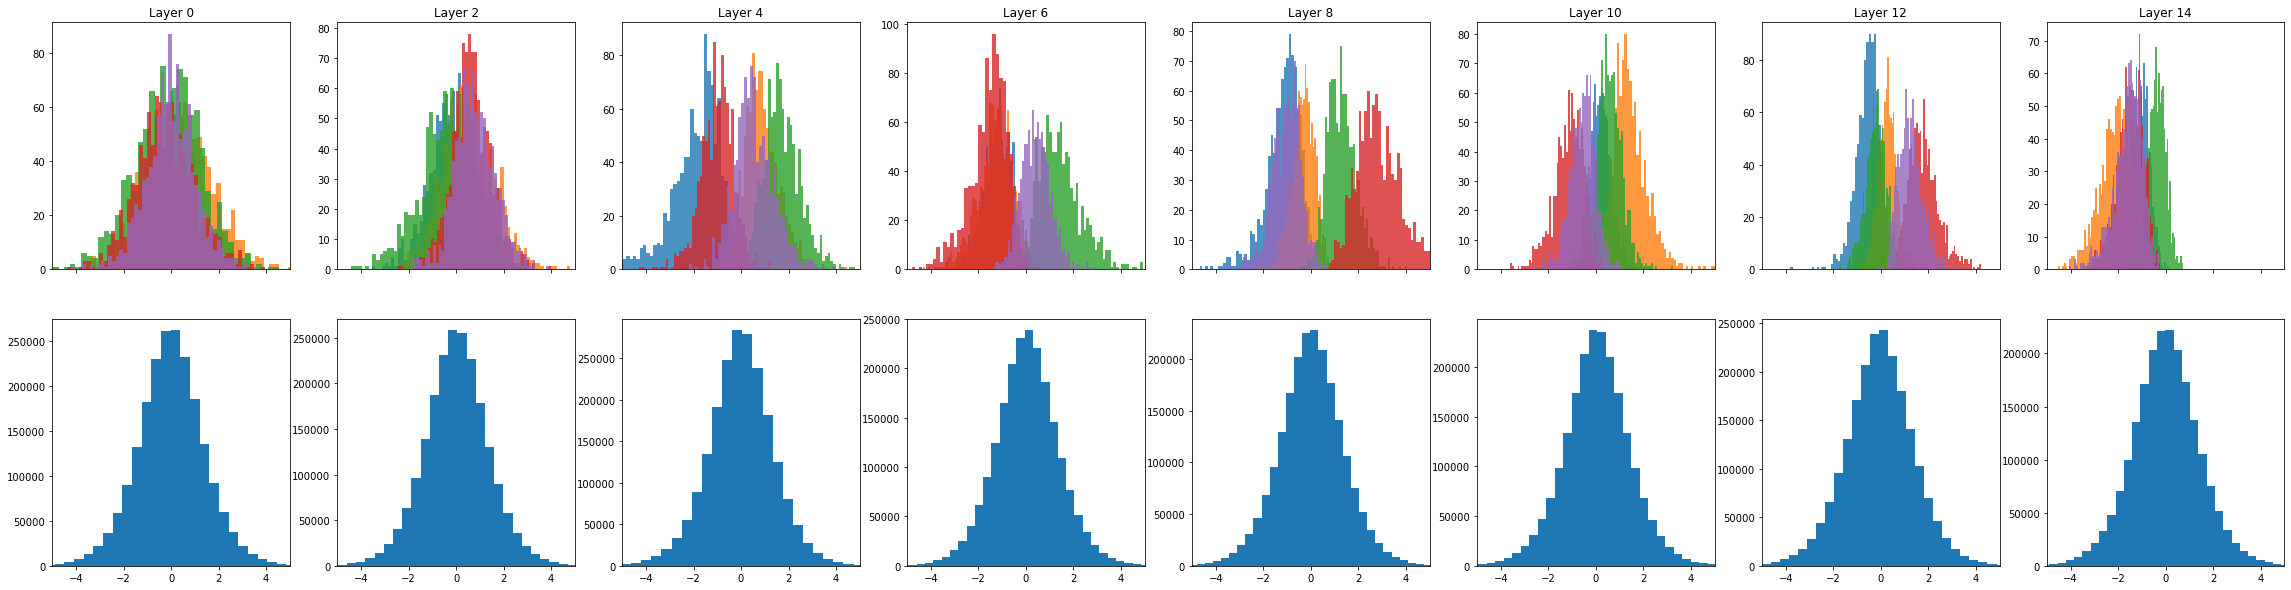

In [14]:
layer_idxs = list(range(0, nlayers, 2))
fig, ax = plt.subplots(2, len(layer_idxs), figsize=(5*len(layer_idxs), 5*2), sharex=True)

for i, layer_idx in enumerate(layer_idxs):
    histogram(preactivations[layer_idx], ax[1, i])
    ax[0, i].set_xlim(-5, 5)
    ax[1, i].set_xlim(-5, 5)
    ax[0, i].set_title(f"Layer {layer_idx}")
    for neuron_idx in neuron_idxs:
        histogram(preactivations[layer_idx][:, neuron_idx], ax[0, i], alpha=.8) 

### Observation:

The per-neuron distributions gradually increase their mean and decrease their standard deviation with depth. 

It means that the function computed by the neural net gradually becomes a constant function.

Let's visualize what "a constant function" means by visualizing the activation vectors at each layer.

Activation features are high dimensional vectors, so we can not visualize them easily.

We use the following two different visualization techniques to visualize them:

1. Let's look only at the first two neurons of each layer, and plot the activation values as x,y coordinates.

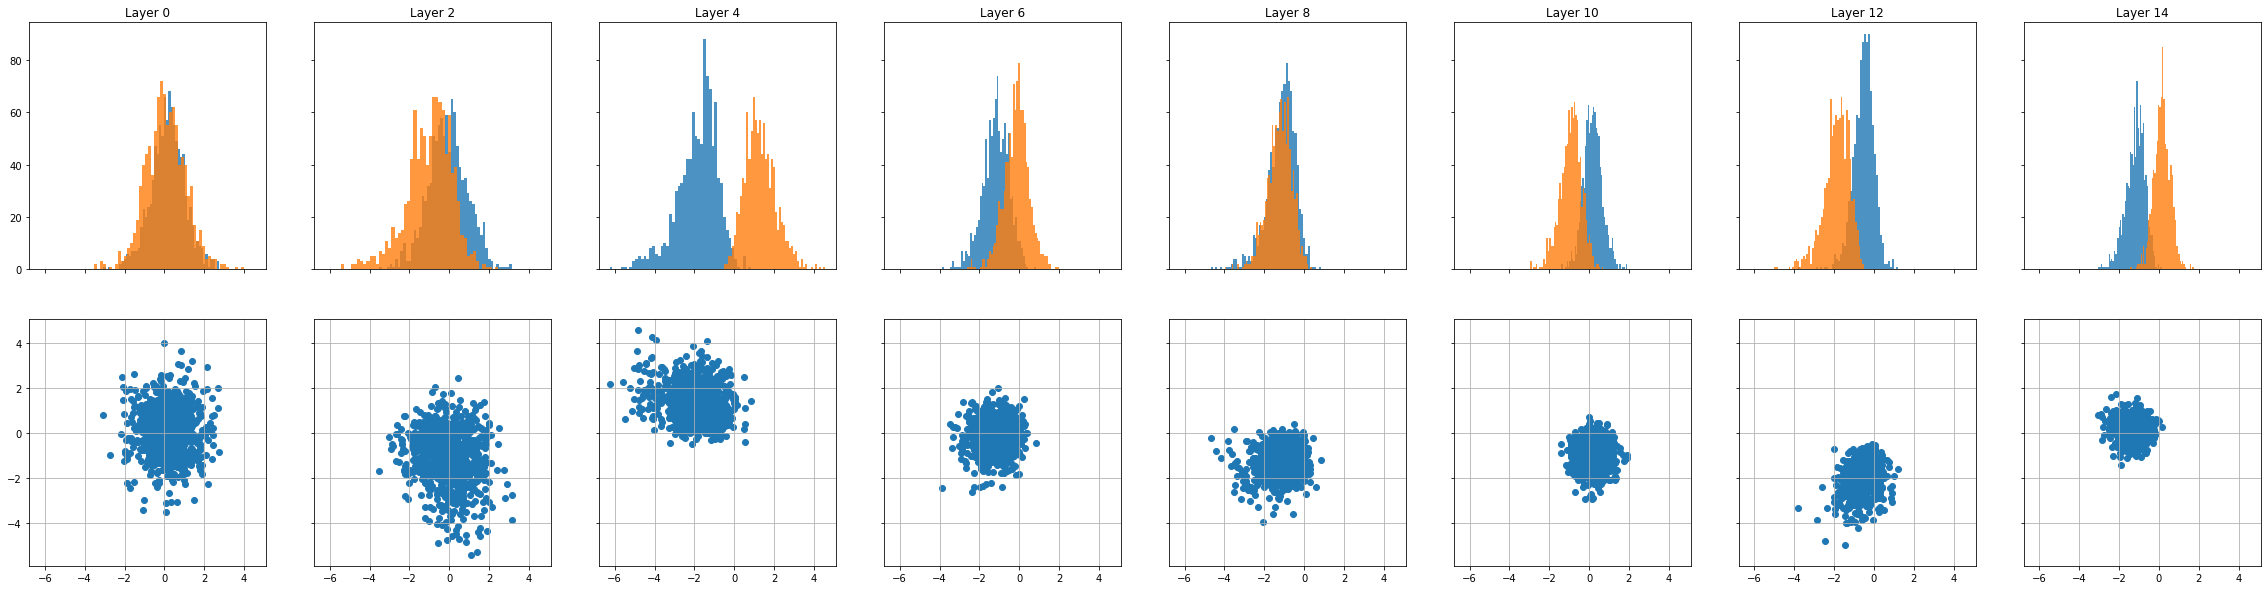

In [15]:
neuron_idxs = [0, 2]
layer_idxs = list(range(0, nlayers, 2))
fig, ax = plt.subplots(2, len(layer_idxs), figsize=(5*len(layer_idxs), 5*2), sharex=True, sharey="row")

for i, layer_idx in enumerate(layer_idxs):
    ax[0, i].set_title(f"Layer {layer_idx}")
    all_data = [to_numpy(preactivations[layer_idx][:, neuron_idx]) for neuron_idx in neuron_idxs]
    [histogram(data, ax[0, i], alpha=.8) for data in all_data]
    x, y = all_data
    ax[1, i].scatter(x, y)
    ax[1, i].grid()
    

![model_2](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_2.png)

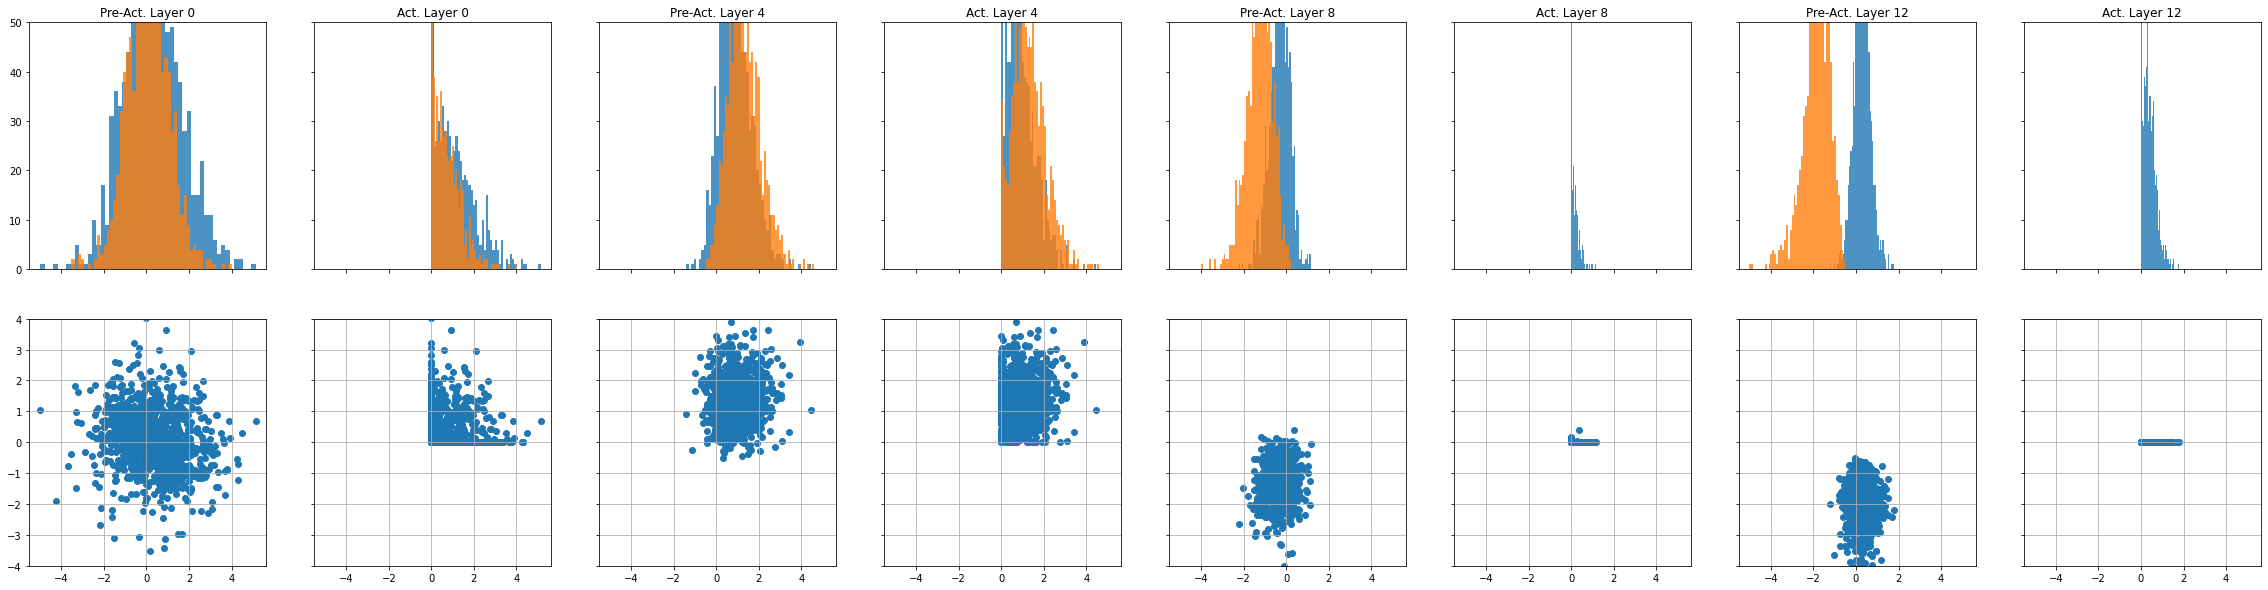

In [16]:
neuron_idxs = [5, 2]
layer_idxs = list(range(0, nlayers, 4))
fig, ax = plt.subplots(2, len(layer_idxs)*2, figsize=(5*2*len(layer_idxs), 5*2), sharex=True, sharey="row")
#plt.grid()
for i, layer_idx in enumerate(layer_idxs):
    ax[0, 2*i].set_title(f"Pre-Act. Layer {layer_idx}")
    ax[0, 2*i+1].set_title(f"Act. Layer {layer_idx}")
    
    ax[0, 2*i].set_ylim(0, 50)
    ax[0, 2*i+1].set_ylim(0, 50)
    ax[1, 2*i].set_ylim(-4, 4)
    ax[1, 2*i+1].set_ylim(-4, 4)
    
    
    all_data = [to_numpy(preactivations[layer_idx][:, neuron_idx]) for neuron_idx in neuron_idxs]
    [histogram(data, ax[0, 2*i], alpha=.8) for data in all_data]
    x, y = all_data
    ax[1, 2*i].scatter(x, y)
    ax[1, 2*i].grid()
    
    
    all_data = [to_numpy(torch.nn.functional.relu(preactivations[layer_idx][:, neuron_idx])) for neuron_idx in neuron_idxs]
    [histogram(data, ax[0, 2*i+1], alpha=.8) for data in all_data]
    x, y = all_data
    ax[1, 2*i+1].scatter(x, y)
    ax[1, 2*i+1].grid()

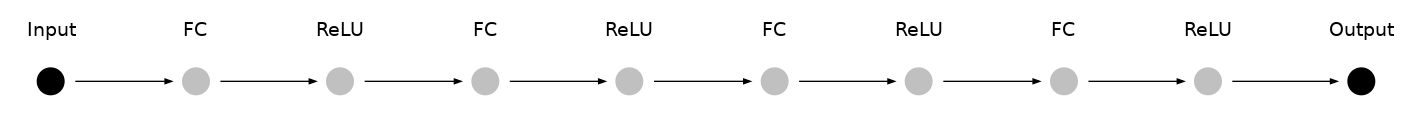

2. Let's look at the 5 random neurons and plot the distributions of these vectors as violons.

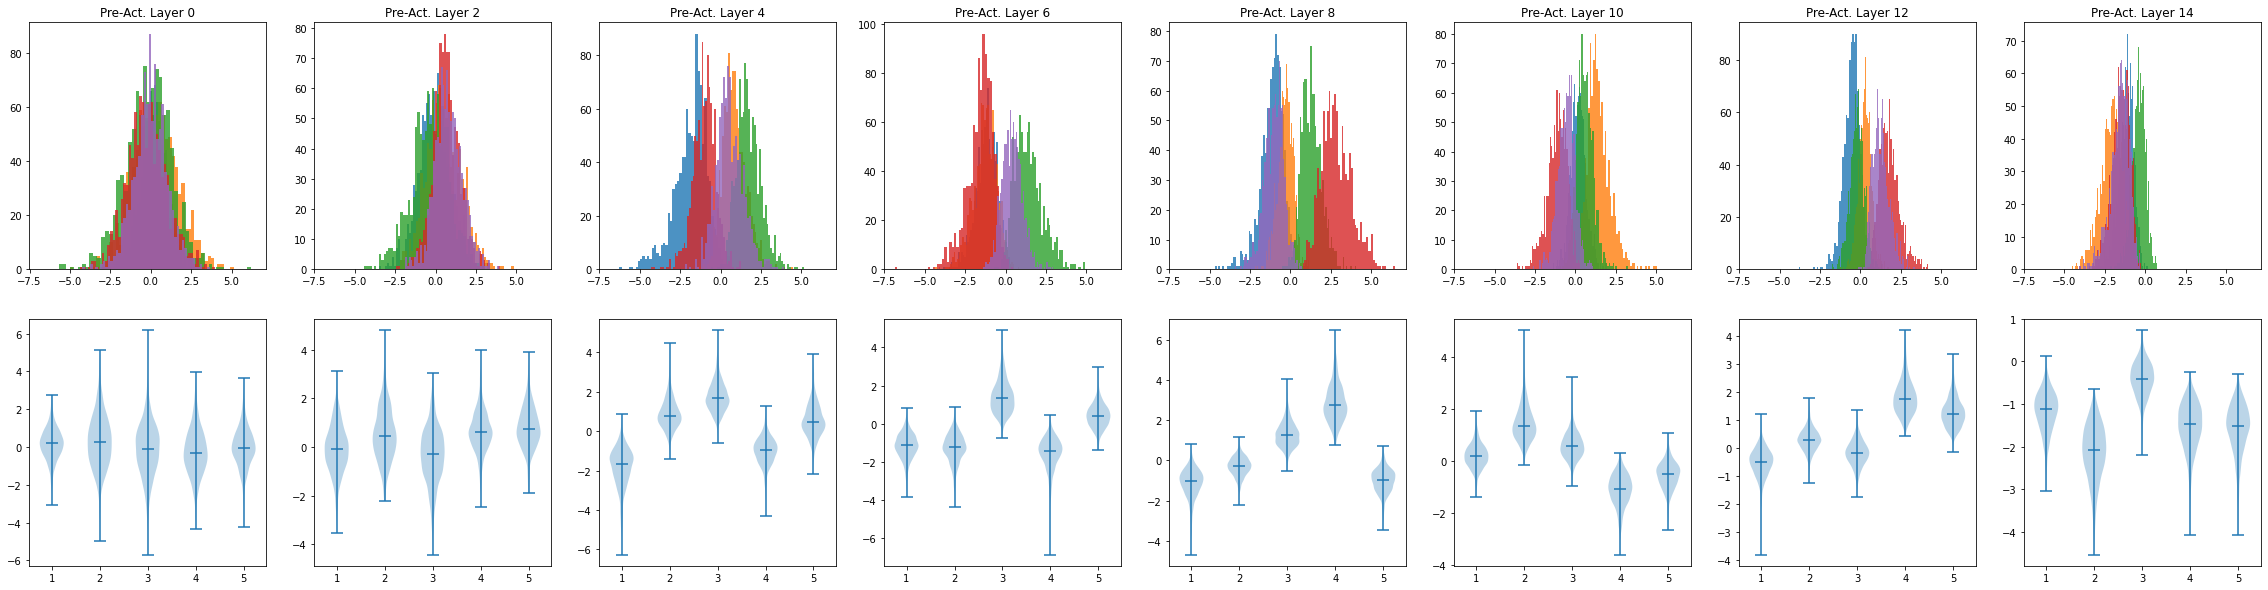

In [17]:
neuron_idxs = [0, 5, 9, 135, 1054]
layer_idxs = list(range(0, nlayers, 2))
fig, ax = plt.subplots(2, len(layer_idxs), figsize=(5*len(layer_idxs), 5*2), sharex="row")

for i, layer_idx in enumerate(layer_idxs):
    ax[0, i].set_title(f"Pre-Act. Layer {layer_idx}")
    all_data = [to_numpy(preactivations[layer_idx][:, neuron_idx]) for neuron_idx in neuron_idxs]
    for data in all_data:
        histogram(data, ax[0, i], alpha=.8) 
    ax[1, i].violinplot(all_data, showmeans=False, showmedians=True)

![model_2](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_2.png)

### What was wrong in the original ReLU paper of kaiming's initialization? 

The variance preserved in kaiming's initialization is the "total variance" of the activations.

The "total variance" represents the variance of the distribution of activations accross all neurons of a layer

In [18]:
layer_idx = 5
preactivation = preactivations[layer_idx]

In [19]:
# The total variance is the variance considering the whole 
# activation distribution, accross all neurons
total_variance = preactivation.var(dim=(0,1))
total_variance.item()

1.847627878189087

- The total variance is the sum of two terms:

    - the intra-neuron variance: the varaince of activations for each neuron)
    
    - and the inter-neuron variance: the variance of each neuron's mean distribution

In [20]:
# The per-neuron variance is the variance of the preactivations of each neurons:
per_neuron_variance = preactivation.var(dim=0)
print(f"There is {per_neuron_variance.shape[0]} neurons, each of which has one distribution")
print(f"The average per-neuron variance is {per_neuron_variance.mean()}")

There is 2048 neurons, each of which has one distribution
The average per-neuron variance is 0.5738601684570312


In [21]:
# The neuron_mean_variance is the variance of the distribution of each neurons' mean:
mean_neuron_variance = preactivation.mean(dim=0)
mean_neuron_variance.var().item()

1.2749496698379517

In [22]:
# The total variance is the sum of both variances:
print(f"{total_variance.item()}, {(mean_neuron_variance.var() + per_neuron_variance.mean()).item()}")
# these are provably equal for infinite width MLP (i.e. with infinite numbers of neurons)
# In our case, they are almost equal, but not completely sue to finiteness

1.847627878189087, 1.848809838294983


However, we do not care about the inter-neuron variance.

What we really want to preserve is the intra-neuron variance.

Let's look at how these two variances evolve with the network's depth:

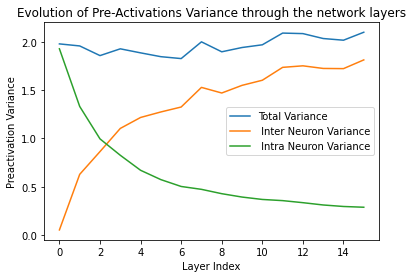

In [23]:
stds = [x.var(0).mean().item() for x in preactivations[:-1]]
means = [x.mean(0).var().item() for x in preactivations[:-1]]
full = [x.var().item() for x in preactivations[:-1]]

plt.plot(full, label="Total Variance")
plt.plot(means, label=" Inter Neuron Variance")
plt.plot(stds, label=" Intra Neuron Variance")
plt.title("Evolution of Pre-Activations Variance through the network layers")
plt.xlabel("Layer Index")
plt.ylabel("Preactivation Variance")
plt.legend();

Kaiming's initialization is "wrong" in the sense that it was preserving the total variance instead of the intra-neuron variance.

In order to preserve the total variance, 

the scaling factor of activations introduced by the Kaiming initialization 

mostly increases the inter-neuron variance by increasing the mean of each neuron distribution 


_______
## 3. Consequence [30 min.]

- This network is very difficult to train by gradient descent because:
    - 3.A. Optimization is a fight between first and second order effects [5 min]
    - 3.B. First order derivatives: Vanishing gradients [5 min.]
    - 3.C. Second order derivatives: Explosion of second order effects. "Curvature Explosion" [20 min.]
________

### 3.A. Optimization is a fight between first and second order effects
__________________

#### 3.A.1. Notations

We consider:

- Model $f_{\theta}$, parameterized by $\theta \in \Theta$
- Training data of $N$ pairs of images and labels $\{(x_i,y_i)\}_N$
- Loss function $\mathcal{L}$ applied to $\mathcal{L}(\theta) = \sum_{i} \mathcal{L}(f_{\theta}(x_i), y_i)$

__________________

#### 3.A.2. optimization problem

Training the model $f_{\theta}$ consists in solving the following optimization problem by gradient descent

$\theta^* = min_{\theta \in \Theta} \mathcal{L}(\theta)$

A step of gradient descent is taken by updating its parameters in the direction opposite to its gradient

$\theta_{t+1} \leftarrow \theta_{t} + \Delta \theta$

$\Delta \theta = - \mu \times \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t}$


We want to know by how much a step $\Delta \theta$ of GD  will decrease the loss: 

$\Delta \mathcal{L} = \mathcal{L}(\theta_{t+1}) - \mathcal{L}(\theta_{t}) $

$\Delta \mathcal{L} =  \mathcal{L}(\theta_{t} + \Delta \theta) - \mathcal{L}(\theta_{t})$

To analyse this, we will use the Taylor decomposition of the loss function

_________________________

#### 3.A.3. Taylor Series decomposition

For a scalar function $f : \mathbb{R} \rightarrow \mathbb{R}$:

$f(x + \Delta x)= f(x) + \frac{\delta \mathcal{f}}{\delta x} \Delta x 
+ \frac{\delta^2 \mathcal{f}}{\delta^2 x} \Delta x^2  
+ ...
+ \frac{\delta^N \mathcal{f}}{\delta^N x} \Delta x^N  
$


$f(x + \Delta x)= f(x) + \frac{\delta \mathcal{f}}{\delta x} \Delta x 
+ \frac{\delta^2 \mathcal{f}}{\delta^2 x} \Delta x^2  
+ \mathcal{O}(\Delta x ^3)
$

For a multidimensional function $f : \mathbb{R}^n \rightarrow \mathbb{R}$:

The second derivative is called the Hessian $H$, and is defined as:

$
H = \begin{pmatrix}
\frac{\delta^2 \mathcal{f}}{\delta x_1 \delta x_1} & \cdots & \frac{\delta^2 \mathcal{f}}{\delta x_1 \delta x_n} \\
\vdots & \ddots & \vdots \\
\frac{\delta^2 \mathcal{f}}{\delta x_n \delta x_1} & \cdots & \frac{\delta^2 \mathcal{f}}{\delta x_n \delta x_n}  \\
\end{pmatrix} 
$

And the second order term of the Taylor series decomposition is the bilinear form:

$f(x + \Delta x)= f(x) + \frac{\delta \mathcal{f}}{\delta x} \Delta x 
+ \Delta x H \Delta x  
+ \mathcal{O}(\Delta x ^3)
$




_______________________________

Thus we can analyze by how much one step of SGD will decrease the loss by looking at this update: 

$\Delta \mathcal{L} =  \mathcal{L}(\theta_{t} + \Delta \theta) - \mathcal{L}(\theta_{t})$

$\Delta \mathcal{L} =  
\mathcal{L}(\theta_{t})
+ \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t} \Delta \theta 
+ \Delta \theta H \Delta \theta
- \mathcal{L}(\theta_{t})
+ O(\Delta \theta^3)
$

$\Delta \mathcal{L} =  
\frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t} \Delta \theta 
+ \Delta \theta H \Delta \theta
$

__________________

In the case of pure Gradient descent, $\Delta \theta = - \mu \times \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t}$, so the equation becomes:

$\Delta \mathcal{L} =  
- \mu || \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t} ||^2  
+ \mu^2 || \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t} ||_H^2
+ \mathcal{O}(\mu^3)
$

The first term $- \mu || \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t} ||^2  $ is always negative: it decreases the loss

The second term $\mu^2 || \frac{\delta \mathcal{L(\theta_t)}}{\delta \theta_t} ||_H^2$ is always positive: it increases the loss

#### B. First order derivatives: Vanishing gradients

Consider the extreme where the intra-neuron variance has vanished to 0:

The network then computes a constant function: $\forall x \in \Omega , f_{\theta}(x) = C $

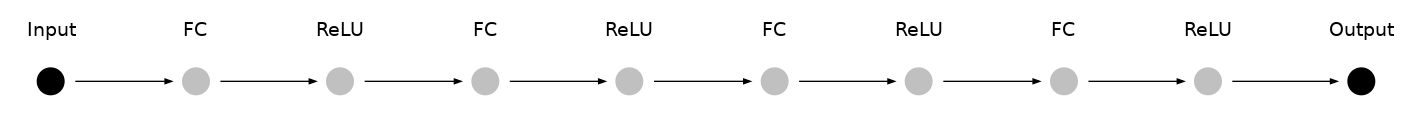

Now let's split our network between the first and upper layers  $y = f_{\theta_{>1}}(f_{\theta_1}(x))$ with

$z = f_{\theta_1}(x)$

$y = f_{\theta_{>1}}(z)$

As the upper layers computes a constant function $y = f_{\theta_{>1}}(z)=C$, one can see that:

$\frac{\delta y}{\delta z}=0$

Thus, $\frac{\delta y}{\delta \theta_1}=\frac{\delta y}{\delta z}\frac{\delta z}{\delta \theta_1} =0$

The gradient of the lower layer has vanished.

Reduction of the inter-neuron variance corresponds to a vanishing gradient phase.

The exact rate of vanishing gradient can be derived theoretically for inifinte width networks.

This is the "Deep Information Propagation" theory, using mean field approximation, also called "Edge of Chaos initialization" [1]

[1] Schoenholz, Samuel S., et al. "Deep information propagation." arXiv preprint arXiv:1611.01232 (2016).

#### C. Second order derivatives: Explosion of second order effects

In [24]:
from ipywidgets import FloatSlider, interact, interactive, fixed, interact_manual

dl_fn = lambda x,y,w:  ((x * ((x * w) - y))).mean(-1)
ddl_fn = lambda x,y,w:  (x**2).mean(-1)

def get_loss_dls(x, y, params):
    losses = loss_fn(x[None], y[None], params[:,None])
    dl = dl_fn(x[None],  y[None], params[:, None])
    ddl = (x**2).sum() * torch.ones_like(params)
    return losses, dl, ddl

def plot_illustration_1D(theta):
    x = base_X
    y = x * param + noise
    losses, dl, ddl = get_loss_dls(x, y, params)
    
    fig, ax = plt.subplots(1, 4, figsize=(4*4, 4), sharey="col")

    ax[0].scatter(x.numpy(), y.numpy())
    ax[0].plot([-10, 10], [-10*theta, 10*theta], color="red")
    ax[0].set_xlim(-10,10)
    ax[0].set_ylim(-10,10)
    ax[0].set_title("$y=f(x)$")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[1].set_title(r"$\mathcal{L}(theta)$")
    ax[1].plot(params.numpy(), losses.numpy())
    ax[1].scatter([theta], [loss_fn(x,y,theta)],color="red")
    ax[1].set_ylim(0,100)
    ax[1].set_xlabel(r"$\theta$")
    ax[1].set_title(r"$ \mathcal{L} $")

    ax[2].set_title("FD=f(theta)")
    ax[2].plot(params.numpy(), dl.numpy())
    ax[2].scatter([theta], dl_fn(x,y,theta),color="red")
    ax[2].set_ylim(-40,100)
    ax[2].set_xlabel(r"$\theta$")
    ax[2].set_title(r"$ \frac{ \delta \mathcal{L}}{\delta \theta } $")

    ax[3].plot(params.numpy(), ddl.numpy());
    ax[3].scatter([theta], ddl[0], color="red")
    ax[3].set_xlabel(r"$\theta$")
    ax[3].set_title(r"$ \frac{ \delta^2 \mathcal{L}}{\delta^2 \theta } $")


__________________________

To understand what Second Order Effectes mean, let us use a simple Least Square regression model.

Given:

- An input vector $X \in \mathbb{R}^N$
- Labels $Y \in \mathbb{R}^N$
- A model made of a unique parameter $\theta = w \in \mathbb{R}$
__________________________

In [25]:
N = 100
noise = .9
noise = torch.randn(N) * noise
base_X = torch.randn((N,))*3
param = .7
params = param - torch.arange(param - 2, param + 2, .1)

__________________________
The loss term is is the Mean Squared Error (MSE):

$\mathcal{L} = \frac{1}{2} || w  X - Y ||^2$

$\mathcal{L} = \frac{1}{2} \sum_{i} (x_i \cdot w - y_i)^2$

$\mathcal{L} = \frac{1}{2} \sum_{i} x_i^2\cdot w^2 - ( 2 \cdot y_i \cdot x_i ) \cdot w + y_i^2$
__________________________

In [26]:
loss_fn = lambda x,y,w: 2 * (((x * w) - y)**2).mean(-1)

In [27]:
interact(plot_illustration_1D, theta=FloatSlider(value=0., min=-2, max=2));

interactive(children=(FloatSlider(value=0.0, description='theta', max=2.0, min=-2.0), Output()), _dom_classes=…

__________________________

The gradients is defined as follow:

$\frac{\delta \mathcal{L}}{\delta  w} = \frac{1}{2} \sum_{i} 2  x_i \cdot (x_i \cdot w - y_i) $

$\frac{\delta \mathcal{L}}{\delta  w} = \sum_{i} x_i \cdot (x_i \cdot w - y_i) $

$\frac{\delta \mathcal{L}}{\delta  w} = \sum_{i} x_i \cdot e_i $

$\frac{\delta \mathcal{L}}{\delta  w} = X \cdot E $


In [28]:
dl_fn = lambda x,y,w:  ((x * ((x * w) - y))).mean(-1)

__________________________

And the second order term as follows

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = \sum_{i} x_i^2$

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = X \cdot X$


In [29]:
ddl_fn = lambda x,y,w:  (x**2).mean(-1)

__________________________

This model does not have higher order terms:

$\frac{\delta^3 \mathcal{L}}{\delta^3 w} = 0$

__________________________

Hence, a step of gradient descent can be fully described by its second order taylor expansion:

$\Delta \mathcal{L} =  
- \mu \times ( \sum_{i} x_i \cdot (x_i \cdot w - y_i) ) 
+ \mu^2 \times (\sum_{i} x_i^2)
$

$\Delta \mathcal{L} =  
- \mu \times ( X \cdot E ) 
+ \mu^2 \times ( X \cdot X )
$

In [30]:
def plot_different_orders_1D(mean):
    rows = 1
    fig, ax = plt.subplots(rows, 4, figsize=(4*4, 4*rows), sharey="col")

    param = .7

    x = base_X + mean
    y = x * param + noise
    losses, dl, ddl = get_loss_dls(x,y, params)

    ax[0].plot([-10, 10], [-10*param, 10*param], color="grey", alpha=.5)
    ax[0].scatter(x.numpy(), y.numpy())
    ax[0].scatter([0], [0], color="cyan")
    ax[0].scatter([mean], [mean * param], color="red")
    ax[0].set_title("$y=f(x)$")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].set_xlim(-10,10)
    ax[0].set_ylim(-10,10)

    ax[1].plot(params.numpy(), losses.numpy())
    ax[1].set_ylim(0,100)
    ax[1].set_xlabel(r"$\theta$")
    ax[1].set_title(r"$ \mathcal{L} $")

    ax[2].plot(params.numpy(), dl.numpy())
    ax[2].set_ylim(-40,100)
    ax[2].set_xlabel(r"$\theta$")
    ax[2].set_title(r"$ \frac{ \delta \mathcal{L}}{\delta \theta } $")

    ax[3].plot(params.numpy(), ddl.numpy());
    ax[3].set_ylim(0, 4000)
    ax[3].set_xlabel(r"$\theta$")
    ax[3].set_title(r"$ \frac{ \delta^2 \mathcal{L}}{\delta^2 \theta } $")


In [31]:
interact(plot_different_orders_1D, mean=FloatSlider(value=0, min=-5, max=5));

interactive(children=(FloatSlider(value=0.0, description='mean', max=5.0, min=-5.0), Output()), _dom_classes=(…

### Observation:

It is much more difficult to optimize non-centered data: Why?

Let's look at the Second Order term (SO)

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = \frac{1}{N} \sum_{i} x_i^2$

let's add some notation: (For simplicity we omit the scaling term $\frac{1}{N}$)

$\dot x = E[X] = \sum_i x_i$  the mean value of $x$.

$\hat X = X - \dot x$ the centered values of $x$

$Var[X] = E[(X-\dot x)^2] = E[\hat X^2]$

We can the re-write the second order term:

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = \sum_{i} x_i^2$

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = \sum_{i} (\dot x + \hat x_i)^2$

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = \sum_{i} \dot x^2 + \hat x_i^2 + 2 \dot x \hat x_i$

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = Var[X] + \dot x^2 + 2 \dot x E[ \hat X]$

The last term is negligible, so we have:

$\frac{\delta^2 \mathcal{L}}{\delta^2 w} = Var[X] + \dot x^2 $


__________________________

Now let's look at what happens for higher dimensional models.

Given:

- An input vector $X \in \mathbb{R}^{N \times 2}$
- Labels $Y \in \mathbb{R}^{N}$
- A model made of 2 parameters $\theta = w \in \mathbb{R}^2$

__________________________


In [32]:
N = 100

base_X = torch.randn((N, 2))*3 
mean = torch.FloatTensor([0., 0.])
param = torch.FloatTensor([2.3, -1.8])[:,None].requires_grad_(True)
noise = torch.randn(N) * .9
x = base_X + mean
y = x.mm(param).squeeze()

print(f"Input X has shape {x.shape}")
print(f"Output Y has shape {y.shape}")
print(f"Parameter has shape {param.shape}")

Input X has shape torch.Size([100, 2])
Output Y has shape torch.Size([100])
Parameter has shape torch.Size([2, 1])


__________________________

The loss term is is the Mean Squared Error (MSE):

$\mathcal{L} = \frac{1}{2} || Xw - Y ||^2$

$\mathcal{L} = \frac{1}{2} (wXX^Tw^T - 2Xw \cdot Y - Y \cdot Y)$

__________________________

In [33]:
loss_fn = lambda x, params, y: ((x.mm(params).squeeze() - y[:,None])**2).mean(0)

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
import pandas as pd
import numpy as np


def get_loss_dls_2(x, y, param, delta_param):
    ddls = x.t().mm(x).numpy()
    torch.set_grad_enabled(True)
    params = (param + torch.from_numpy(np.dstack(np.meshgrid(delta_param, delta_param))).float().view(-1, 2).t()).detach().requires_grad_(True)
    loss = loss_fn(x, params, y)
    loss.sum().backward()
    dls = params.grad
    torch.set_grad_enabled(False);
    return loss.detach().numpy(), dls.detach().numpy(), ddls

def plot_2d_opt(base_X, y, param, means=[-3, -2, -1, 0, 1, 2, 3]):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'surface'}]])
    fig.add_scatter3d(z=[0], x=[0], y=[0], marker={"size":2, "color":"cyan"}, 
                      mode="markers", row=1, col=1)
    

    for mean_ in means:
        mean = mean_ * param.t()
        x = base_X + mean
        y = x.mm(param).squeeze() + noise
        delta_param = np.linspace(-2, 2, 10)
        loss, dls, ddls = get_loss_dls_2(x, y, param, delta_param)

        ax1_X = x[:,0]
        ax1_Y = x[:,1]
        ax1_Z = y
        ax2_X, ax2_Y = param[0] + delta_param, param[1] + delta_param
        ax2_Z = loss.reshape(10,10)

        visible = True if mean_==0 else False 
        # Model scatter plot
        fig.add_scatter3d(z=ax1_Z, x=ax1_X, y=ax1_Y, marker={"size":1, "color":"blue"}, 
                          mode="markers", row=1, col=1, visible=visible)#
        fig.add_scatter3d(z=[ax1_Z.mean()], x=[ax1_X.mean()], y=[ax1_Y.mean()], 
                          marker={"size":2, "color":"red"}, mode="markers", 
                          row=1, col=1, visible=visible)
        # Loss surface
        fig.add_surface(z=ax2_Z, x=ax2_X, y=ax2_Y, 
                        row=1, col=2, visible=visible)

    steps = []
    for i in range(len(means)):
        step = dict(
            method = 'restyle',  
            args = ['visible', [True] + [False] * (len(fig.data)-1)],
        )
        step['args'][1][i*3+1] = True
        step['args'][1][i*3+2] = True
        step['args'][1][i*3+3] = True
        steps.append(step)

    sliders = [dict(
        steps = steps,
        active=3
    )]


    fig.layout.sliders = sliders
    fig.update_layout(showlegend=False,
                     scene = dict(
                         xaxis = dict(nticks=3, range=[-10,10],),
                         yaxis = dict(nticks=3, range=[-10,10],),
                         zaxis = dict(nticks=3, range=[-15,15],),),
                     scene2 = dict(
                         zaxis = dict(nticks=3, range=[0,100],),),
                      width=1200, 
                      height=600
                     )
    # Edit slider labels
    fig['layout']['sliders'][0]['currentvalue']['prefix']='Mean: '
    for i, mean_ in enumerate(means):
        fig['layout']['sliders'][0]['steps'][i]['label']=mean_

    fig.show()

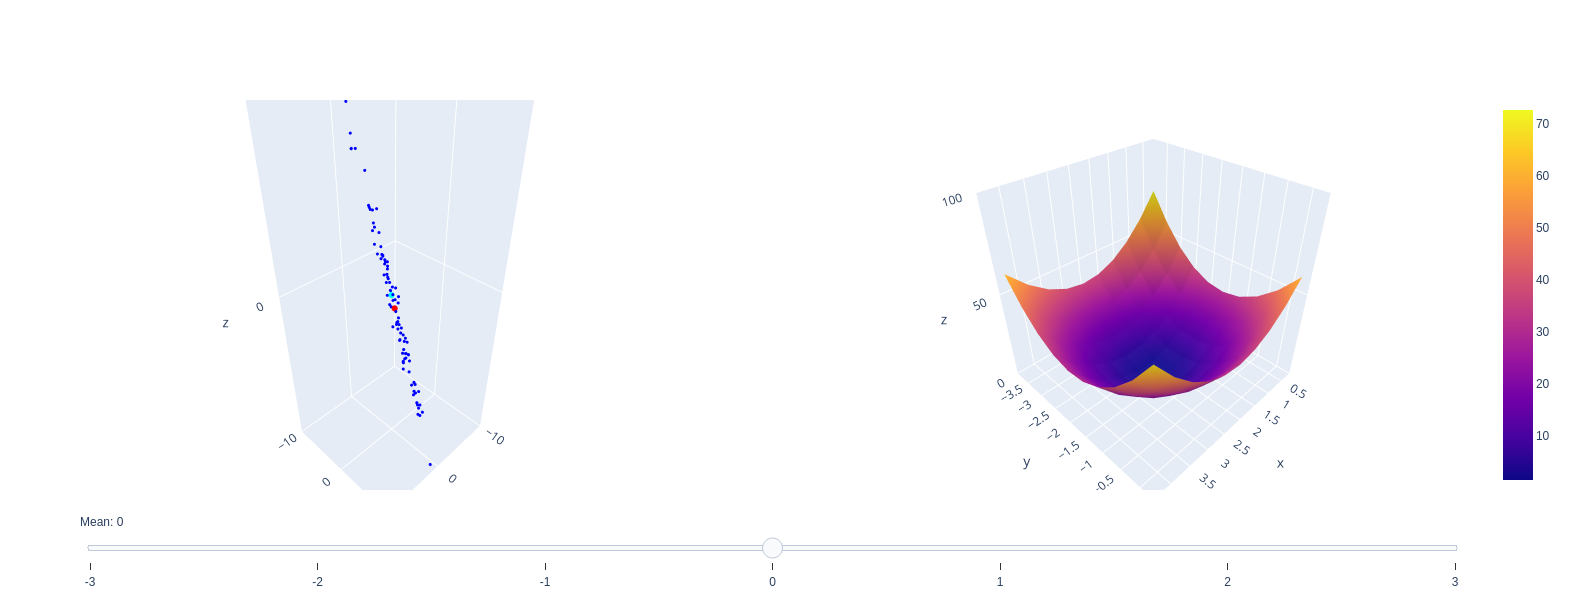

In [35]:
plot_2d_opt(base_X, y, param)

__________________________

The gradients are defined as follows:

$\frac{\delta \mathcal{L}}{\delta  w} = \frac{1}{2} (2 XX^T w - 2 X \cdot Y) $

$\frac{\delta \mathcal{L}}{\delta  w} = X \cdot ( X^T w -  Y) $

$\frac{\delta \mathcal{L}}{\delta  w} = X \cdot E $


__________________________

And the second order terms are defined as follows

$H_w = \frac{\delta^2 \mathcal{L}}{\delta^2 w} = XX^T$

Let's split $X$ into a mean vector $x_mean$ and the deviation around its mean $X_{dev}$: $X = x_{mean} + X_{dev}$

The Hessian is then defined as:

$H_w = N \times X_{mean}X_{mean}^T + X_{dev} X_{dev}^T + 2 X_{mean} X_{dev}^T $

$H_w = N \times E[X]E[X]^T + Cov[X, X] + 2 E[X] X^T$

__________________________


In [36]:
N = 1000
M = 1#5
base_x = M * torch.randn(N, 2)
mean_x = M * torch.randn(1, 2) * M
mean_x

tensor([[-0.5933,  0.6970]])

In [37]:
#mean = torch.FloatTensor([.7, 1.5])
X = base_x + mean_x

XXt = X.t().mm(X)
XXt

tensor([[1392.5298, -497.5712],
        [-497.5712, 1499.2860]])

In [38]:
XX1 = base_x.t().mm(base_x)
XX1 

tensor([[990.0999, -39.1948],
        [-39.1948, 977.6952]])

In [39]:
XX2 = mean_x.t().mm(mean_x)
N * XX2

tensor([[ 352.0539, -413.5363],
        [-413.5363,  485.7560]])

In [40]:
XX3 = (base_x[:,:,None]*mean_x[None]).sum(0)
XX3

tensor([[ 25.1880, -29.5868],
        [-15.2532,  17.9171]])

In [41]:
XX1 + N * XX2  + 2 * (base_x[:,:,None]*mean_x[None]).sum(0)

tensor([[1392.5297, -511.9047],
        [-483.2376, 1499.2853]])

### What does it mean for our neural network?

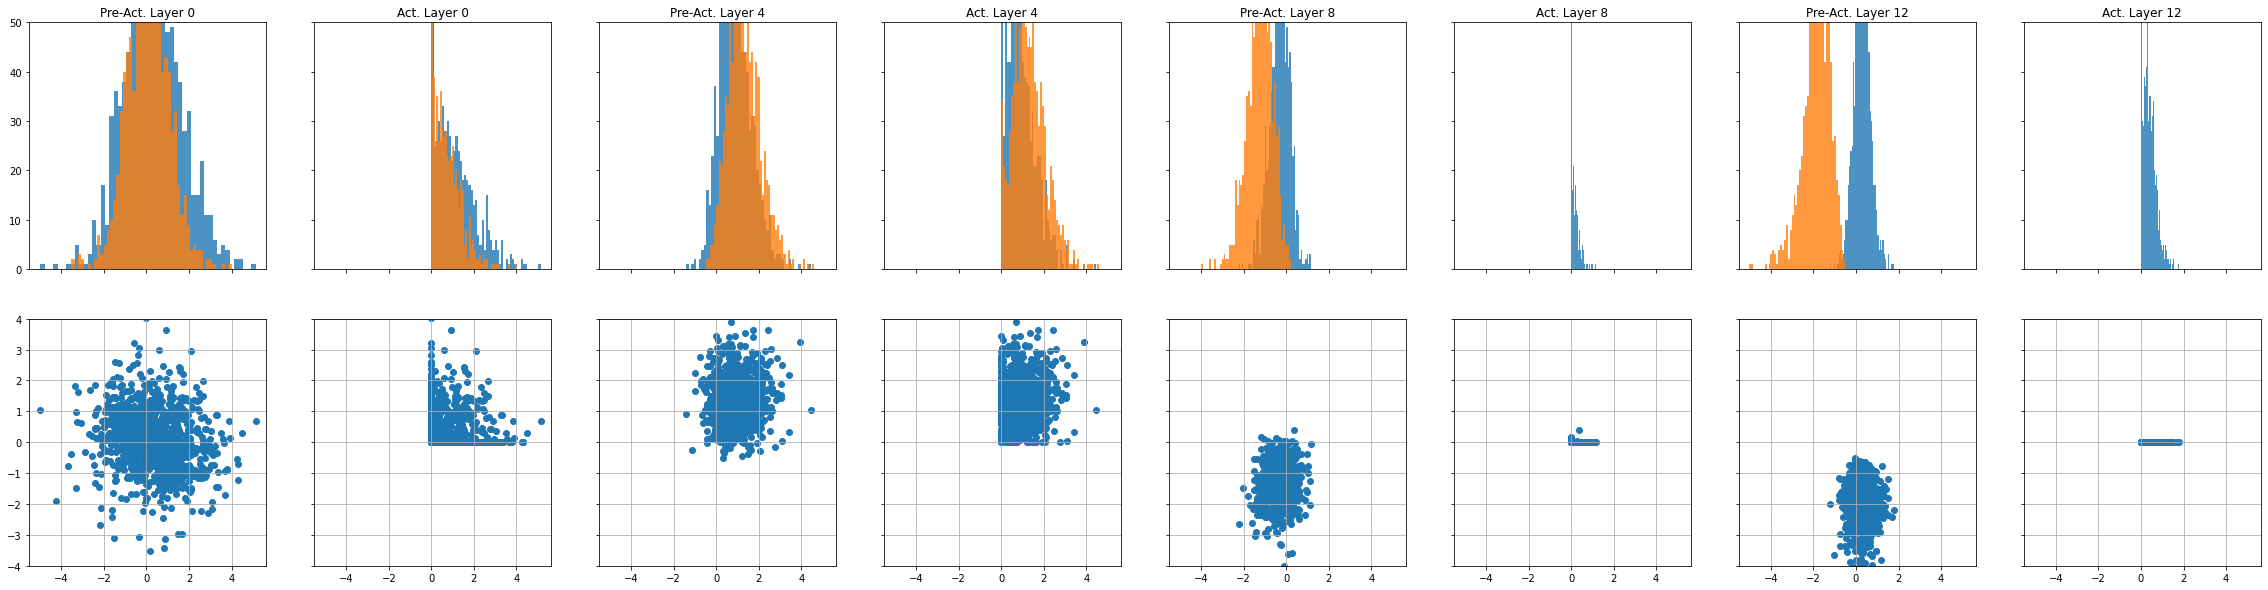

In [42]:
neuron_idxs = [5, 2]
layer_idxs = list(range(0, nlayers, 4))
fig, ax = plt.subplots(2, len(layer_idxs)*2, figsize=(5*2*len(layer_idxs), 5*2), sharex=True, sharey="row")
#plt.grid()
for i, layer_idx in enumerate(layer_idxs):
    ax[0, 2*i].set_title(f"Pre-Act. Layer {layer_idx}")
    ax[0, 2*i+1].set_title(f"Act. Layer {layer_idx}")
    
    ax[0, 2*i].set_ylim(0, 50)
    ax[0, 2*i+1].set_ylim(0, 50)
    ax[1, 2*i].set_ylim(-4, 4)
    ax[1, 2*i+1].set_ylim(-4, 4)
    
    
    all_data = [to_numpy(preactivations[layer_idx][:, neuron_idx]) for neuron_idx in neuron_idxs]
    [histogram(data, ax[0, 2*i], alpha=.8) for data in all_data]
    x, y = all_data
    ax[1, 2*i].scatter(x, y)
    ax[1, 2*i].grid()
    
    
    all_data = [to_numpy(torch.nn.functional.relu(preactivations[layer_idx][:, neuron_idx])) for neuron_idx in neuron_idxs]
    [histogram(data, ax[0, 2*i+1], alpha=.8) for data in all_data]
    x, y = all_data
    ax[1, 2*i+1].scatter(x, y)
    ax[1, 2*i+1].grid()

![model_1](https://raw.githubusercontent.com/TristHas/Teaching/main/archi_1.png)

### Last layer:

Consider the loss function is the MSE loss:

Then, the Analysis of the curvature is the same as we just saw:

The curvature of the loss, equals to $XX^T$, is dominated by the mean of the last layer activations.

In practice, we do not use the MSE loss but the NLL loss. 

However, the same qualitative phenomenon happens as well, for any convex loss. 


### Lower layers:

For lower layers, the Hessian is given by the following terms:

$Z_{i} = W_i \cdot X_{i}$

$H_W = X_iX_i^T \otimes H_Z$ ([1])

The first term of the right hand term is again dominate by the mean outer product.

[1] Dangel, Felix, Stefan Harmeling, and Philipp Hennig. "Modular block-diagonal curvature approximations for feedforward architectures." International Conference on Artificial Intelligence and Statistics. PMLR, 2020.

### 4. Remedy: How can we solve this problem?

- Most successful methods for neural net training actually tackle this problem:
    - Batch Norm
    - Residual networks
    - Data-dependant initialization

____________________

#### 4.1 The effect of Batch Norm

Batch normalization is very directly tackling this problem:

At each layer, batch normalization substracts the mean, and divide by the standard deviation of the per-neuron distribution:

$z_{i,j} = \frac{x_{i,j} - E[X_i]}{\sqrt Var[X_i]}$

$y_{i,j} = z_{i,j} * \gamma_i + \beta_i$

____________________

In [43]:
layer_idx  = 10
x = preactivations[layer_idx]
z = (x - x.mean(0, keepdim=True)) / x.std(0, keepdim=True)

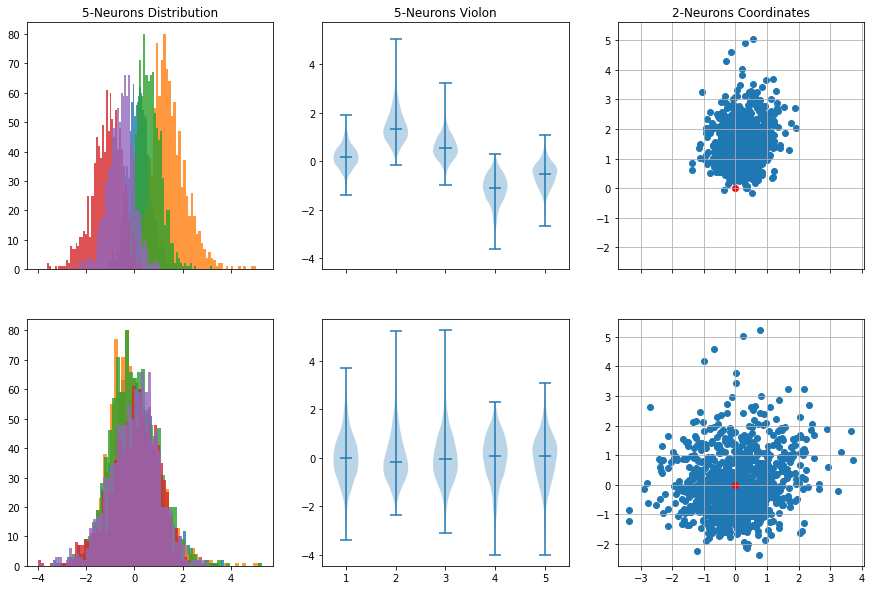

In [44]:
neuron_idxs = [0, 5, 9, 135, 1054]
layer_idxs = list(range(0, nlayers, 2))
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex="col", sharey="col")

ax[0, 0].set_title(f"5-Neurons Distribution")
ax[0, 1].set_title(f"5-Neurons Violon")
ax[0, 2].set_title(f"2-Neurons Coordinates")

all_x = [to_numpy(x[:, neuron_idx]) for neuron_idx in neuron_idxs]
all_z = [to_numpy(z[:, neuron_idx]) for neuron_idx in neuron_idxs]

for data in all_x:
    histogram(data, ax[0, 0], alpha=.8) 
for data in all_z:
    histogram(data, ax[1, 0], alpha=.8) 

ax[0, 1].violinplot(all_x, showmeans=False, showmedians=True)
ax[1, 1].violinplot(all_z, showmeans=False, showmedians=True);

x_x, x_y = all_x[:2]
ax[0, 2].scatter(x_x, x_y)
ax[0, 2].scatter([0], [0], color="red")
ax[0, 2].grid()

z_x, z_y = all_z[:2]
ax[1, 2].scatter(z_x, z_y)
ax[1, 2].scatter([0], [0], color="red")
ax[1, 2].grid()

This directly fixes our problem!


#### At initialization

$\beta=0$  and $\gamma=1$.

Hence, no shit is induced at all, and the second order term induced by the activation outer product $XX^T$ is minimal


####nn.BatchNorm1d During Training

$\beta$ becomes non-zero, which creates a shift in the per-neuron activation mean (i.e. inter-neuron variance).

However, this shift is not dependant on previous layer, and thus does not accumulate through the network.

Furthermore, Batch norm has an additional benefit, which we only mention in this section:

It reduces the amount of second order effects on the activations themselves, i.e., the $H_z$ term in the following equation:

$H_W = X_iX_i^T \otimes H_Z$ 


In [52]:
class MLP_bn(nn.Module):
    def __init__(self, in_dim, out_dim, nlayers, width):
        super().__init__()
        # Define architecture
        self.in_layer = nn.Linear(in_dim, width)
        self.out_layer = nn.Linear(width, out_dim, bias=False)
        self.layers = nn.ModuleList([nn.Linear(width, width) \
                                     for i in range(nlayers)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(width) for i in range(nlayers)])
        self.relu = nn.ReLU()
        
        # Initialize
        self.init_kaiming(self.in_layer)
        self.init_kaiming(self.out_layer)
        [self.init_kaiming(layer) for layer in self.layers]
        
    def forward(self, x):
        return self.get_activations(x)[-1]
        
    def get_activations(self, x):
        x = self.in_layer(x)
        preact = [x]
        for layer,bn in zip(self.layers, self.bns):
            x = bn(layer(self.relu(x)))
            preact.append(x)
        x = self.out_layer(self.relu(x))
        preact.append(x) 
        return preact
    
    def init_kaiming(self, layer):
        with torch.no_grad():
            nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
            if layer.bias is not None:
                layer.bias.zero_()

In [66]:
bs, channels, H, W = imgs.shape
input_dim = channels * H * W
output_dim = lbls.max().item() + 1

nlayers = 15
width = 2048

model = MLP_bn(in_dim=input_dim, out_dim=output_dim, nlayers=nlayers, width=width).to(device)
x = ((imgs.view(batch_size, -1)  - imgs.mean()) / imgs.std()).to(device)
preactivations_bn = model.get_activations(x)

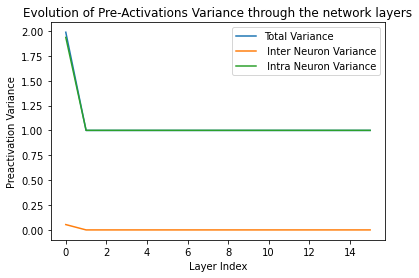

In [67]:
stds = [x.var(0).mean().item() for x in preactivations_bn[:-1]]
means = [x.mean(0).var().item() for x in preactivations_bn[:-1]]
full = [x.var().item() for x in preactivations_bn[:-1]]

plt.plot(full, label="Total Variance")
plt.plot(means, label=" Inter Neuron Variance")
plt.plot(stds, label=" Intra Neuron Variance")
plt.title("Evolution of Pre-Activations Variance through the network layers")
plt.xlabel("Layer Index")
plt.ylabel("Preactivation Variance")
plt.legend();

____________________

#### 4.2 The effect of Residual Connections

Residual connections also prevent the activations from increasing mean and losing variance.


In [45]:
x = preactivations[0]
y = preactivations[1]
z = x/np.sqrt(2) + y/np.sqrt(2)
x.std().item(), y.std().item(), z.std().item()

(1.4071526527404785, 1.3996175527572632, 1.4045766592025757)

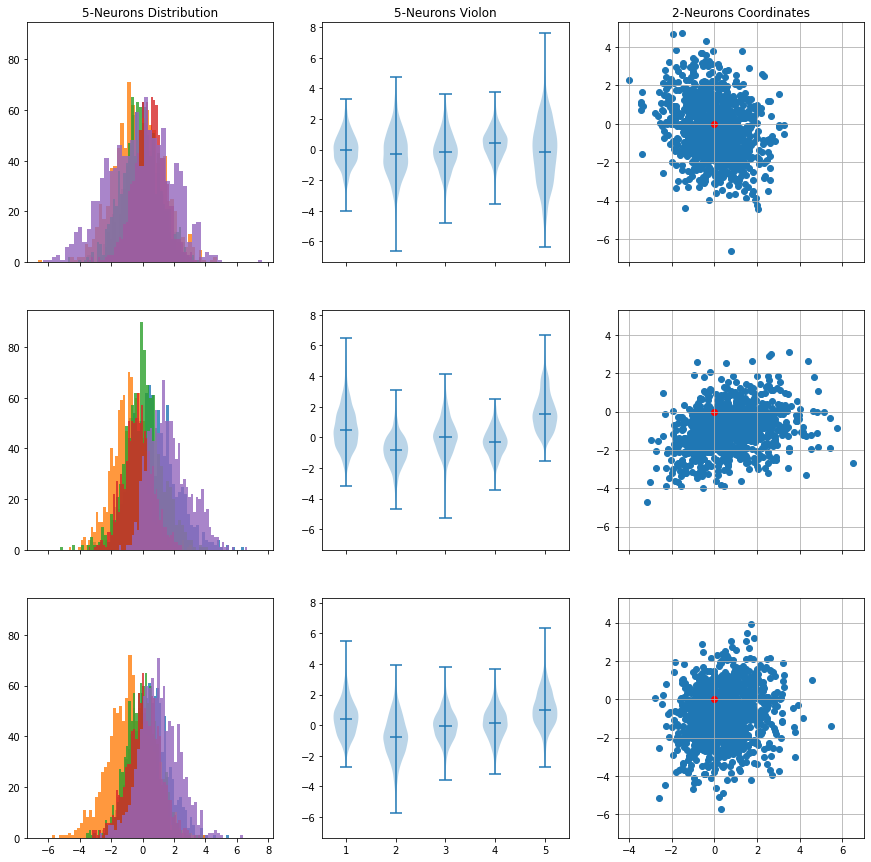

In [46]:
neuron_idxs = np.random.choice(2048, 5)
layer_idxs = list(range(0, nlayers, 2))
fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex="col", sharey="col")

ax[0, 0].set_title(f"5-Neurons Distribution")
ax[0, 1].set_title(f"5-Neurons Violon")
ax[0, 2].set_title(f"2-Neurons Coordinates")

all_x = [to_numpy(x[:, neuron_idx]) for neuron_idx in neuron_idxs]
all_y = [to_numpy(y[:, neuron_idx]) for neuron_idx in neuron_idxs]
all_z = [to_numpy(z[:, neuron_idx]) for neuron_idx in neuron_idxs]

for data in all_x:
    histogram(data, ax[0, 0], alpha=.8) 
for data in all_y:
    histogram(data, ax[1, 0], alpha=.8) 
for data in all_z:
    histogram(data, ax[2, 0], alpha=.8) 

ax[0, 1].violinplot(all_x, showmeans=False, showmedians=True)
ax[1, 1].violinplot(all_y, showmeans=False, showmedians=True);
ax[2, 1].violinplot(all_z, showmeans=False, showmedians=True);

x_x, x_y = all_x[:2]
ax[0, 2].scatter(x_x, x_y)
ax[0, 2].scatter([0], [0], color="red")
ax[0, 2].grid()

y_x, y_y = all_y[:2]
ax[1, 2].scatter(y_x, y_y)
ax[1, 2].scatter([0], [0], color="red")
ax[1, 2].grid()

z_x, z_y = all_z[:2]
ax[2, 2].scatter(z_x, z_y)
ax[2, 2].scatter([0], [0], color="red")
ax[2, 2].grid()

Residual connnections help slow down the per-neuron mean shift.

The exact attenuation rate can be derived in infinite width networks [1]:

[1] Yang, Greg, and Samuel S. Schoenholz. "Mean field residual networks: on the edge of chaos." Proceedings of the 31st International Conference on Neural Information Processing Systems. 2017.

In [61]:
class MLP_res(nn.Module):
    def __init__(self, in_dim, out_dim, nlayers, width):
        super().__init__()
        # Define architecture
        self.in_layer = nn.Linear(in_dim, width)
        self.out_layer = nn.Linear(width, out_dim, bias=False)
        self.layers = nn.ModuleList([nn.Linear(width, width) \
                                     for i in range(nlayers)])
        self.relu = nn.ReLU()
        
        # Initialize
        self.init_kaiming(self.in_layer)
        self.init_kaiming(self.out_layer)
        [self.init_kaiming(layer) for layer in self.layers]
        
    def forward(self, x):
        return self.get_activations(x)[-1]
        
    def get_activations(self, x):
        x = self.in_layer(x)
        preact = [x]
        for layer in self.layers:
            x = layer(self.relu(x)) / np.sqrt(2) + x / np.sqrt(2)
            preact.append(x)
        x = self.out_layer(self.relu(x))
        preact.append(x) 
        return preact
    
    def init_kaiming(self, layer):
        with torch.no_grad():
            nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
            if layer.bias is not None:
                layer.bias.zero_()


In [62]:
bs, channels, H, W = imgs.shape
input_dim = channels * H * W
output_dim = lbls.max().item() + 1

nlayers = 15
width = 2048

model = MLP_res(in_dim=input_dim, out_dim=output_dim, nlayers=nlayers, width=width).to(device)
x = ((imgs.view(batch_size, -1)  - imgs.mean()) / imgs.std()).to(device)
preactivations_res = model.get_activations(x)

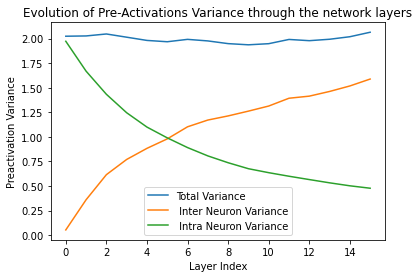

In [63]:
stds = [x.var(0).mean().item() for x in preactivations_res[:-1]]
means = [x.mean(0).var().item() for x in preactivations_res[:-1]]
full = [x.var().item() for x in preactivations_res[:-1]]

plt.plot(full, label="Total Variance")
plt.plot(means, label=" Inter Neuron Variance")
plt.plot(stds, label=" Intra Neuron Variance")
plt.title("Evolution of Pre-Activations Variance through the network layers")
plt.xlabel("Layer Index")
plt.ylabel("Preactivation Variance")
plt.legend();

#### 4.3 The effect of data dependant initialization schemes

Coming soon...

## 5. Conclusion

### The problem

- Optimization is a fight between first and second order terms.

- ReLU Neural Networks are naturally biased towards low intra-neuron variation and high inter-neuron variation.

- The shift in per-neuron mean distribution results in vanishing gradients and exploding curvature.

- This situation leads to slow optimization.

### The solutions

- Most of the breakthrough in Neural Net optimization were unknowingly tackling that problem:
    - BatchNorm
    - ResNet
    - Data-dependant initialization and meta-init
    - Optimizers (Not talked about today)

### Relationship with existing theory:

- Edge of chaos
- Second order term definition: Hessian propagation


_______________________________

# Additional Notes


First order term:
1. Edge of chaos initialization and mean field theory

Second order term:

1. The Hessian of NN concentrate on the block-diagonal (cf. Gross)
2. The leading eigenvectors of the Hessian can be interpreted.

Convolutional Neural networks:

1. What we saw directly apply to CNN: One neuron in our analysis=one channel in CNN
2. Max pooling further amplifies this phenomenon as it further increases the channel means.  


_______________________________

# Additional pointers


By lack of time, we did not cover the following points.

These are the next most important phenomenons in deep model optimization, and the subject of future course.

#### A. Additional Practical Considerations

- Interpretation of the directions of maximum curvature [https://myrtle.ai/learn/how-to-train-your-resnet-7-batch-norm/]
- Exploding gradient problems with Batch Normalization [Yang, Greg, et al. "A Mean Field Theory of Batch Normalization." International Conference on Learning Representations. 2018.]
- Positive interaction between Batch Normalization and Residual Connections [De, Soham, and Sam Smith. "Batch Normalization Biases Residual Blocks Towards the Identity Function in Deep Networks." Advances in Neural Information Processing Systems 33 (2020).]
- Stochasticity and second order effects (SGD noise) [https://openai.com/blog/science-of-ai/]
- The role of overparameterization (large width) on second order effects [Du, Simon S., et al. "Gradient Descent Provably Optimizes Over-parameterized Neural Networks." International Conference on Learning Representations. 2018.]
- Momentum [https://distill.pub/2017/momentum/], ADAM [], LAMB []

#### B. Further Theory

- Deep Information Propagation: Edge of Chaos initialization [Schoenholz, Samuel S., et al. "Deep information propagation." arXiv preprint arXiv:1611.01232 (2016).]
- Saddle points in Neural networks [Dauphin, Yann, et al. "Identifying and attacking the saddle point problem in high-dimensional non-convex optimization." arXiv preprint arXiv:1406.2572 (2014).]
- Deep Linear Networks and Dynamical Isometry [Pennington, Jeffrey, Schoenholz, Sam, and Ganguli, Surya.
Resurrecting the sigmoid in deep learning through dy-
namical isometry: theory and practice. NIPS, 2017.]
- Neural Tangent Kernel [http://www.offconvex.org/2019/10/03/NTK/]